In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import time
import progressbar

# Get our VGG and Resnet models
from torchvision.models import vgg16, vgg19, VGG16_Weights, VGG19_Weights
from torchvision.models import resnet50, resnet152, ResNet50_Weights, ResNet152_Weights

# Imports for Data
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms, Resize
from torchvision.transforms.functional import to_pil_image
from torchvision.io import read_image

DIMENSION = 224
BATCH_SIZE = 64
DATA_SIZE = 24000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
widgets = [
    ' [',
    progressbar.Timer(format= 'elapsed time: %(elapsed)s'),
    '] ',
    progressbar.Bar('*'),' (',
    progressbar.ETA(), ') ',
]
print(device)

100%|██████████| 170498071/170498071 [00:05<00:00, 33882123.54it/s]


Extracting /root/data/CIFAR/cifar-10-python.tar.gz to /root/data/CIFAR
Files already downloaded and verified


<class 'torch.Tensor'>
Train length x: 24000, y: 10000
Current Device: cuda


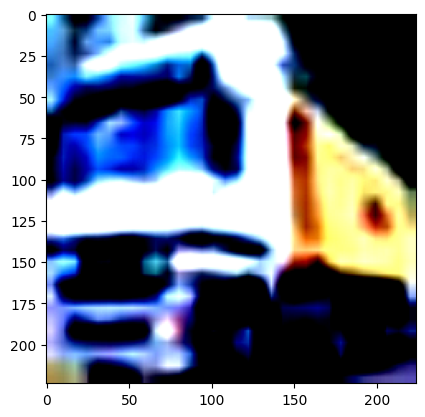

In [ ]:
# Set Up Data
preprocess = transforms.Compose([
        transforms.Resize((DIMENSION, DIMENSION)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

# Load data from CIFAR and trim it down
train = CIFAR10('~/data/CIFAR', download=True, train=True, transform=preprocess)
test = CIFAR10('~/data/CIFAR', download=True, train=False, transform=preprocess)
train = torch.utils.data.Subset(train, list(range(0, DATA_SIZE)))

# Create data loaders objects
train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

# Take a peak at the data
print(type(train[0][0]))
plt.imshow(train[1][0].cpu().permute(1, 2, 0))
print(f"Train length x: {len(train)}, y: {len(test)}")
print(f"Current Device: {device}")


In [ ]:
# Training code
def train_batch(model, X_train, Y_train, opt, loss_func):

  opt.zero_grad()                       # Flush memory
  pred = model(X_train)
  batch_loss = loss_func(pred, Y_train) # Compute loss
  batch_loss.backward()                 # Compute gradients
  opt.step()                            # Make a GD step

  return batch_loss.detach().cpu().numpy()


def accuracy(model, test_loader):
  correct = 0
  total = 0

  # Set the model to evaluation mode
  model.eval()

  # Disable gradient calculation
  print("Computing accuracy...")
  start = time.time()
  bar = progressbar.ProgressBar(max_value=len(test_loader), widgets=widgets).start()
  with torch.no_grad():
      for i, batch in enumerate(test_loader):
          inputs, labels = batch
          inputs = inputs.to(device)  # Send inputs to the device (CPU or GPU)
          labels = labels.to(device)  # Send labels to the device

          # Forward pass
          outputs = model(inputs)

          # Get predicted class labels
          _, predicted = torch.max(outputs, 1)

          # Update counts
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          bar.update(i)

  # Calculate accuracy
  accuracy = (correct / total) * 100.0
  testing_time = time.time() - start
  return accuracy, testing_time


def train_model(model, epochs, optimizer, loss):

  # Put model in training mode
  model.train()
  losses, is_accuracies, os_accuracies, n_epochs = [], [], [], epochs
  start = time.time()
  for epoch in range(n_epochs):
      print(f"Running epoch {epoch + 1} of {n_epochs}")
      bar = progressbar.ProgressBar(max_value=len(train_dl), widgets=widgets).start()
      epoch_losses = []

      # Loop to train each batch and measure its loss value
      for i, batch in enumerate(train_dl):
          x, y = batch
          x, y = x.to(device), y.to(device)
          batch_loss = train_batch(model, x, y, optimizer, loss)
          epoch_losses.append(batch_loss)
          bar.update(i)

      # Log and track epoch progress
      epoch_loss = np.mean(epoch_losses)
      losses.append(epoch_loss)
      print()
      print(f"Epoch {epoch + 1} had loss of {epoch_loss}")

  training_time = time.time() - start
  return training_time

In [ ]:

# Code we want to run to test each model
def test_model(model):
  test_accuracy, inference_time = accuracy(model, test_dl)
  print()
  print(f"Test Accuracy: {test_accuracy}")
  print(f"Inference time: {inference_time}")


In [ ]:
# Define and train the vgg models
vgg_models = [
    vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(device),
    vgg19(weights=VGG19_Weights.IMAGENET1K_V1).to(device),
]

for model in vgg_models:

  # Disable training for VGG's feature layers
  for param in model.features.parameters():
    param.requires_grad = False

  # Set up the model with our classifier
  model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1)).to(device)
  model.classifier = nn.Sequential(
                                   nn.Linear(512,128),
                                   nn.ReLU(),
                                   nn.Dropout(0.2),
                                   nn.Linear(128,10),
                                   nn.Sigmoid()).to(device)
  summary(model, (3, DIMENSION, DIMENSION))

  # Train the model
  loss_func = nn.CrossEntropyLoss().to(device)
  opt = Adam(model.parameters(), lr=1e-3)
  training_time = train_model(model, 5, opt, loss_func)

  # Print some training stats
  print(f"Total training time: {training_time}")

  # Test the model
  test_model(model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 89.3MB/s]
 [elapsed time: 0:00:00] |                                  | (ETA:  --:--:--) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

 [elapsed time: 0:00:00] |                                  | (ETA:  --:--:--) 


Epoch 1 had loss of 1.8031169176101685
Total training time: 176.86976766586304
Computing accuracy...


 [elapsed time: 0:01:13] |********************************* | (ETA:   0:00:00) 


Test Accuracy: 75.59
Inference time: 73.63277316093445


In [ ]:
# Define and train the resnet models
res_models = [
    resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(device),
    resnet152(weights=ResNet152_Weights.IMAGENET1K_V1).to(device)
]

for model in res_models:

  # Disable training for ResNet's feature layers
  for param in model.parameters():
    param.requires_grad = False

  # Set up the model with our classifier
  model.fc = nn.Sequential(nn.Flatten(),
                           nn.Linear(2048,128),
                           nn.ReLU(),
                           nn.Dropout(0.2),
                           nn.Linear(128,10),
                           nn.Sigmoid()).to(device)
  summary(model, (3, DIMENSION, DIMENSION))

  # Train the model
  loss_func = nn.CrossEntropyLoss().to(device)
  opt = Adam(model.parameters(), lr=1e-3)
  training_time = train_model(model, 5, opt, loss_func)

  # Print some training stats
  print(f"Total training time: {training_time}")

  # Test the model
  test_model(model)


 [elapsed time: 0:00:00] |                                  | (ETA:  --:--:--) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

 [elapsed time: 0:00:00] |                                  | (ETA:  --:--:--) 


Epoch 1 had loss of 1.803289771080017
Running epoch 2 of 5


 [elapsed time: 0:00:00] |                                  | (ETA:  --:--:--) 


Epoch 2 had loss of 1.6824322938919067
Running epoch 3 of 5


 [elapsed time: 0:00:00] |                                  | (ETA:  --:--:--) 


Epoch 3 had loss of 1.660110354423523
Running epoch 4 of 5


 [elapsed time: 0:00:00] |                                  | (ETA:  --:--:--) 


Epoch 4 had loss of 1.6475166082382202
Running epoch 5 of 5


 [elapsed time: 0:00:00] |                                  | (ETA:  --:--:--) 


Epoch 5 had loss of 1.640945315361023
Total training time: 526.4061765670776
Computing accuracy...


 [elapsed time: 0:00:00] |                                  | (ETA:  --:--:--) 


Test Accuracy: 79.86999999999999
Inference time: 41.00989484786987
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 

 [elapsed time: 0:00:00] |                                  | (ETA:  --:--:--) 


Epoch 1 had loss of 1.7549047470092773
Running epoch 2 of 5


 [elapsed time: 0:00:00] |                                  | (ETA:  --:--:--) 


Epoch 2 had loss of 1.6469789743423462
Running epoch 3 of 5


 [elapsed time: 0:00:00] |                                  | (ETA:  --:--:--) 


Epoch 3 had loss of 1.6270564794540405
Running epoch 4 of 5


 [elapsed time: 0:00:00] |                                  | (ETA:  --:--:--) 


Epoch 4 had loss of 1.6175377368927002
Running epoch 5 of 5


 [elapsed time: 0:00:00] |                                  | (ETA:  --:--:--) 


Epoch 5 had loss of 1.611661434173584
Total training time: 999.7853674888611
Computing accuracy...


 [elapsed time: 0:01:18] |********************************* | (ETA:   0:00:00) 


Test Accuracy: 82.91
Inference time: 78.84997916221619


In [ ]:
# Test Some Images from Google
# 2 frogs, 2 ships, 2 airplanes
classes = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}
paths = ["frog1.png", "frog2.png", "ship1.png", "ship2.png", "plane1.png", "plane2.png"]
for path in paths:

  # Get tensor from file
  img = read_image(path)
  img = img[:3, :, :]
  img = to_pil_image(img)

  # Preprocess the image
  img = preprocess(img)

  # Plot image
  plt.imshow(img.permute(1, 2, 0))

  # Check the predicted class
  models = vgg_models + res_models
  for model in models:
    model.eval()
    prediction = model(img[None, :, :, :].to(device))
    prediction = classes[torch.argmax(prediction, 1).item()]
    print(f"Prediction for {path}: {prediction}")
